# Detrended Rice Yield Time Series
The crop yield depends on many factors (geography, soil type, fertiliser use, adoption of new modern high-yielding variety (MV) rice etc.), weather just being one. These other factors though are likely to be systematic (i.e. Evolve slowly over time) and contribute to the general trend in crop yield. i.e. Any fluctuations above or below trend are likely down to weather. Here we test this hypothesis.

We thus need to:

1. Obtain the fluctuations about the average yield
2. Obtain the fluctuations of the weather 

We will do this by using moving averages. We will therefore replace the absolute average yield and absolute temperature values with fluctuation values (We might use z-scores = (value - rolling mean)/std dev ).

If weather plays a role in rice yields, one would expect to see a clear correlation between yield and weather fluctations. Maybe we find that extreme high or low temperatures/rainfall contribute to a poor harvest. 

How to analyse this potential correlation? 

1. Build a model: yield deviation = T1 + T2 + ... T12 + R1 + R2 + ... + R12 (Or a classificayion model where we replace yield deviation with +1 (Good harvest) and -1 (Bad harvest))

2. Perform clustering: For a particular year, cluster the countries on their weather data and calculate the average yield deviation in each group. Is there a significant difference in the values?



In [104]:
# Set the working directory
setwd("/Users/billyhanan/Documents/NCI  Diploma in Data Analytics/Advanced Data Mining/Project")

# Read in primary data file
df1 = read.csv("./Data/Final_crop_data.csv",header=T)

# Delete unnecessary columns
df1$X <- NULL
df1$SEQ_NO <- NULL

# Rename column
names(df1)[3] <- "COUNTRY"

# Read in file with ISO country codes
df_iso = read.csv("./Data/wikipedia-iso-country-codes.csv",header=T)
names(df_iso)[1] <- 'Name'

# Merge two files
df = merge(df1, df_iso, by.x='ISO', by.y='Alpha.3.code')

# Delete redundant columns
df$Alpha.2.code = NULL
df$Numeric.code = NULL
df$ISO.3166.2 = NULL

# Assign values to COUNTRY column
df$COUNTRY = df$Name
df$Name = NULL

# Simplify some of the country names
levels(df$COUNTRY)[levels(df$COUNTRY)=="Bolivia, Plurinational State of"] = "Bolivia"
levels(df$COUNTRY)[levels(df$COUNTRY)=="Brunei Darussalam"] = "Brunei"
levels(df$COUNTRY)[levels(df$COUNTRY)=="Côte d'Ivoire"] = "Ivory Coast"
levels(df$COUNTRY)[levels(df$COUNTRY)=="Iran, Islamic Republic of"] = "Iran"
levels(df$COUNTRY)[levels(df$COUNTRY)=="Korea, Republic of"] = "South Korea"
levels(df$COUNTRY)[levels(df$COUNTRY)=="Lao People's Democratic Republic"] = "Laos"
levels(df$COUNTRY)[levels(df$COUNTRY)=="Macedonia, the former Yugoslav Republic of"] = "Macedonia"
levels(df$COUNTRY)[levels(df$COUNTRY)=="Russian Federation"] = "Russia"
levels(df$COUNTRY)[levels(df$COUNTRY)=="Tanzania, United Republic of"] = "Tanzania"
levels(df$COUNTRY)[levels(df$COUNTRY)=="Venezuela, Bolivarian Republic of"] = "Venezuela"
levels(df$COUNTRY)[levels(df$COUNTRY)=="Viet Nam"] = "Vietnam"

# Remove redundant levels
df=droplevels(df)

# Read in csv file holding total annual paddy rice production 
df1 = read.csv("./Data/wrs_annual_rice_production.csv",header=T)

# Create temporary capitalised country column in Master dataframe
df$CAP_COUNTRY = toupper(df$COUNTRY)

# Merge with master data frame
df2 = merge(df, df1, by.x=c('CAP_COUNTRY','YEAR'), by.y=c('Country','Year'), all.x=T) 

# Shift PRODUCTION column and remove redundant Year and CAP_COUNTRY columns
df = df2[c('COUNTRY','ISO','YEAR','LAND_AREA','HARV_AREA','FERT','YIELD','PRODUCTION','AVG_TEMP_JAN','AVG_TEMP_FEB','AVG_TEMP_MAR','AVG_TEMP_APR','AVG_TEMP_MAY','AVG_TEMP_JUN','AVG_TEMP_JUL','AVG_TEMP_AUG','AVG_TEMP_SEP','AVG_TEMP_OCT','AVG_TEMP_NOV','AVG_TEMP_DEC','AVG_RF_JAN','AVG_RF_FEB','AVG_RF_MAR','AVG_RF_APR','AVG_RF_MAY','AVG_RF_JUN','AVG_RF_JUL','AVG_RF_AUG','AVG_RF_SEP','AVG_RF_OCT','AVG_RF_NOV','AVG_RF_DEC','AVG_Q1_TEMP','AVG_Q2_TEMP','AVG_Q3_TEMP','AVG_Q4_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')]

# Remove unneeded variables
rm(df1)
rm(df2)

library(repr)

# Change plot size 
options(repr.plot.width=6, repr.plot.height=5)

In [105]:
head(df)


COUNTRY,ISO,YEAR,LAND_AREA,HARV_AREA,FERT,YIELD,PRODUCTION,AVG_TEMP_JAN,AVG_TEMP_FEB,⋯,AVG_RF_NOV,AVG_RF_DEC,AVG_Q1_TEMP,AVG_Q2_TEMP,AVG_Q3_TEMP,AVG_Q4_TEMP,AVG_Q1_RF,AVG_Q2_RF,AVG_Q3_RF,AVG_Q4_RF
Afghanistan,AFG,1991,65286,173000,6.140000,1.94,335000,-0.03110,1.43654,⋯,12.66710,38.55690,2.764097,17.69763,22.97277,8.143453,81.26800,38.21139,7.230680,18.43989
Afghanistan,AFG,1992,65286,175000,5.790000,1.71,300000,0.74637,2.46018,⋯,9.92092,47.46040,2.973320,16.89697,21.80963,8.498270,59.46273,44.34204,7.827567,24.41974
Afghanistan,AFG,1993,65286,175000,5.110000,1.71,300000,-0.08350,4.33465,⋯,21.58090,20.68180,3.457163,18.33557,22.52880,7.587023,53.98010,29.86003,5.226967,16.62800
Afghanistan,AFG,1994,65286,180000,5.820435,1.90,342000,1.11415,1.14112,⋯,12.81990,36.94000,3.744203,18.18197,22.22033,8.173570,56.36823,23.07017,11.033253,23.60247
Afghanistan,AFG,1995,65286,170000,5.820435,2.29,390000,0.92358,2.96133,⋯,6.24458,35.71700,3.417947,17.96013,23.05943,7.726067,42.35450,31.69475,7.733073,18.51706
Afghanistan,AFG,1996,65286,175000,0.650000,1.94,340000,-0.48840,2.86922,⋯,9.68384,6.71934,3.225333,17.79007,22.77710,7.208570,63.32300,27.51930,5.784513,10.37393


# Initial Data Exploration

Let us check our data for null or suspicious values

In [106]:
# We have annual data from 1991-2015 (inclusive) for 105 countries 
unique(df$COUNTRY)
cat(paste('Number of countries = ',length(unique(df$COUNTRY))))
unique(df$YEAR)

# Some null values exist however
cat(paste('Number of null values = ',sum(colSums(is.na(df)))))

# And they all exist in the PRODUCTION column
sum(is.na(df$PRODUCTION))

[1] Afghanistan              Algeria                  Angola                  
  [4] Argentina                Australia                Azerbaijan              
  [7] Bangladesh               Belize                   Benin                   
 [10] Bhutan                   Bolivia                  Brazil                  
 [13] Brunei                   Bulgaria                 Burkina Faso            
 [16] Burundi                  Cambodia                 Cameroon                
 [19] Central African Republic Chad                     Chile                   
 [22] China                    Colombia                 Comoros                 
 [25] Congo                    Costa Rica               Cuba                    
 [28] Dominican Republic       Ecuador                  Egypt                   
 [31] El Salvador              Ethiopia                 Fiji                    
 [34] France                   Gabon                    Ghana                   
 [37] Greece                   Guatemala                Guinea                  
 [40] Guinea-Bissau            Guyana                   Haiti                   
 [43] Honduras                 Hungary                  India                   
 [46] Indonesia                Iran                     Iraq                    
 [49] Italy                    Ivory Coast              Jamaica                 
 [52] Japan                    Kazakhstan               Kenya                   
 [55] Kyrgyzstan               Laos                     Macedonia               
 [58] Madagascar               Malawi                   Malaysia                
 [61] Mali                     Mauritania               Mauritius               
 [64] Mexico                   Mozambique               Myanmar                 
 [67] Nepal                    Nicaragua                Niger                   
 [70] Nigeria                  Pakistan                 Panama                  
 [73] Papua New Guinea         Paraguay                 Peru                    
 [76] Philippines              Portugal                 Romania                 
 [79] Russia                   Rwanda                   Senegal                 
 [82] Sierra Leone             Somalia                  South Africa            
 [85] South Korea              Spain                    Sri Lanka               
 [88] Sudan                    Suriname                 Swaziland               
 [91] Tajikistan               Tanzania                 Thailand                
 [94] Togo                     Trinidad and Tobago      Turkey                  
 [97] Turkmenistan             Uganda                   Ukraine                 
[100] United States            Uruguay                  Uzbekistan              
[103] Venezuela                Vietnam                  Zambia                  
105 Levels: Afghanistan Algeria Angola Argentina Australia ... Zambia

Number of countries =  105

[1] 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
[16] 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015

Number of null values =  26

[1] 26

# Data Clean-up and Imputation

Here we investigate the integrity of our data. We check the key target variables YIELD and PRODUCTION for suspicious repeated values. We similarly checked the monthly weather data.

In [107]:
countries_to_impute = c('Azerbaijan','Ethiopia','Kazakhstan','Kyrgyzstan','Macedonia','Russia','Tajikistan','Turkmenistan','Ukraine','Uzbekistan')

for (country in countries_to_impute)
 {
  # Retrieve the year and production values from 1991-1996 for the country
  year_production = subset(df,COUNTRY==country & YEAR<=1996)[c('YEAR','PRODUCTION')]
    
  # Fit Regression line
  model = lm(PRODUCTION ~ YEAR, data=year_production)

  # Retrieve years with NULL production
  null_data = year_production[is.na(year_production$PRODUCTION),]
    
  # Predict missing production values from fitted regression line
  predicted_values = predict(model, newdata=null_data)
    
  # Insert predicted production values into master dataframe
  for (i in 1:length(null_data$YEAR))
   {
    year = null_data$YEAR[i]
      
    if ( predicted_values[[i]] > 0 )
     {
      df[df$COUNTRY==country & df$YEAR==year,'PRODUCTION'] =  predicted_values[[i]]
     }
    else
     {
      print(paste("WARNING: Obtained negative prediction for",country,"in the year",year)) 
     }
   }

 }

# Manually insert value for failed predictions - simply inserted value in most recent year in the future
df[df$COUNTRY=='Azerbaijan' & df$YEAR==1991,'PRODUCTION'] = 622
df[df$COUNTRY=='Kyrgyzstan' & df$YEAR==1991,'PRODUCTION'] = 2800
df[df$COUNTRY=='Mauritius' & is.na(df$PRODUCTION),'PRODUCTION'] = 40


[1] "WARNING: Obtained negative prediction for Azerbaijan in the year 1991"
[1] "WARNING: Obtained negative prediction for Kyrgyzstan in the year 1991"


# Summary

We are now left with full (no missing values) data sets for 94 countries from the years 1991-2015

In [108]:
# We have annual data from 1991-2015 (inclusive) for 105 countries 
unique(df$COUNTRY)
cat(paste('Number of countries = ',length(unique(df$COUNTRY))))
unique(df$YEAR)

# Number of null values 
cat(paste('Number of null values = ',sum(is.na(df))))

[1] Afghanistan              Algeria                  Angola                  
  [4] Argentina                Australia                Azerbaijan              
  [7] Bangladesh               Belize                   Benin                   
 [10] Bhutan                   Bolivia                  Brazil                  
 [13] Brunei                   Bulgaria                 Burkina Faso            
 [16] Burundi                  Cambodia                 Cameroon                
 [19] Central African Republic Chad                     Chile                   
 [22] China                    Colombia                 Comoros                 
 [25] Congo                    Costa Rica               Cuba                    
 [28] Dominican Republic       Ecuador                  Egypt                   
 [31] El Salvador              Ethiopia                 Fiji                    
 [34] France                   Gabon                    Ghana                   
 [37] Greece                   Guatemala                Guinea                  
 [40] Guinea-Bissau            Guyana                   Haiti                   
 [43] Honduras                 Hungary                  India                   
 [46] Indonesia                Iran                     Iraq                    
 [49] Italy                    Ivory Coast              Jamaica                 
 [52] Japan                    Kazakhstan               Kenya                   
 [55] Kyrgyzstan               Laos                     Macedonia               
 [58] Madagascar               Malawi                   Malaysia                
 [61] Mali                     Mauritania               Mauritius               
 [64] Mexico                   Mozambique               Myanmar                 
 [67] Nepal                    Nicaragua                Niger                   
 [70] Nigeria                  Pakistan                 Panama                  
 [73] Papua New Guinea         Paraguay                 Peru                    
 [76] Philippines              Portugal                 Romania                 
 [79] Russia                   Rwanda                   Senegal                 
 [82] Sierra Leone             Somalia                  South Africa            
 [85] South Korea              Spain                    Sri Lanka               
 [88] Sudan                    Suriname                 Swaziland               
 [91] Tajikistan               Tanzania                 Thailand                
 [94] Togo                     Trinidad and Tobago      Turkey                  
 [97] Turkmenistan             Uganda                   Ukraine                 
[100] United States            Uruguay                  Uzbekistan              
[103] Venezuela                Vietnam                  Zambia                  
105 Levels: Afghanistan Algeria Angola Argentina Australia ... Zambia

Number of countries =  105

[1] 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
[16] 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015

Number of null values =  0

# Rolling Averages

Below I define the function get_sma_for_column() that can be used to calculate a rolling average (per country) for any column in dataframe

In [109]:
# Calculate moving average in rice yield time series
sma <- function(x, n = 5){filter(x, rep(1/n, n), sides = 2)}

get_sma_for_column <- function(df,newColName,colName,n){
 # Takes in a dataframe, adds a new column called <newColName> and calculates a simple moving average   
 # on the column <colName> for each country. Note that n = Number of values in moving window 
    
 ' Add new column '
 df[newColName] = NA
 
 for (country in unique(df$COUNTRY))
  {
   df_country = subset(df,COUNTRY==country)
   df[,newColName][df$COUNTRY==country] = sma(df_country[colName],n)
  }
 
 return(df)
}

# Clustering Climate Groups

Here we attempt to group countries with similar climates i.e. Identify groups having similar monthly/seasonal weather patterns. Why? It might be useful to build different models for each grouping i.e. Lead to better prediction

We first get monthly averages for each country and then cluster on these aggregate values.

Note that I am following the cluster tools used in 
https://www.datanovia.com/en/lessons/data-preparation-and-r-packages-for-cluster-analysis/


In [110]:
#install.packages(c("cluster", "factoextra"))
library(cluster)
library(factoextra)

In [117]:
# Obtain quarterly averages for each country
df_avg_weather_by_country = aggregate(df[,33:40], by=list(df$COUNTRY), FUN=mean)
rownames(df_avg_weather_by_country) <- df_avg_weather_by_country$Group.1
df_avg_weather_by_country$Group.1 = NULL

df_avg_temps_by_country <- df_avg_weather_by_country[,1:4]
df_avg_rainfalls_by_country <- df_avg_weather_by_country[,5:8]

# Temperature and Rainfall
We want to put temperature and rainfall values on the same scale. So I calculated

1. The median (med) and interquartile range (IQR) of all the temperature values
2. The median and interquartile range of all the rainfall values

I then rescaled the temperature and rainfall values separately using the transformation (x_i-med)/IQR

Clustering was then run on these rescaled temperature and rainfall values

In [162]:
# Calculate median and Inter-quartile ranges 
median_temp = median(as.matrix(df_avg_temps_by_country))
median_rainfall = median(as.matrix(df_avg_rainfalls_by_country))

iqr_temp = IQR(as.matrix(df_avg_temps_by_country))
iqr_rainfall = IQR(as.matrix(df_avg_rainfalls_by_country))

# Rescale weather data
df_avg_weather_by_country.rescaled = df_avg_weather_by_country 
df_avg_weather_by_country.rescaled[,1:4] = (df_avg_weather_by_country.rescaled[,1:4] - median_temp)/iqr_temp
df_avg_weather_by_country.rescaled[,5:8] = (df_avg_weather_by_country.rescaled[,5:8] - median_rainfall)/iqr_rainfall


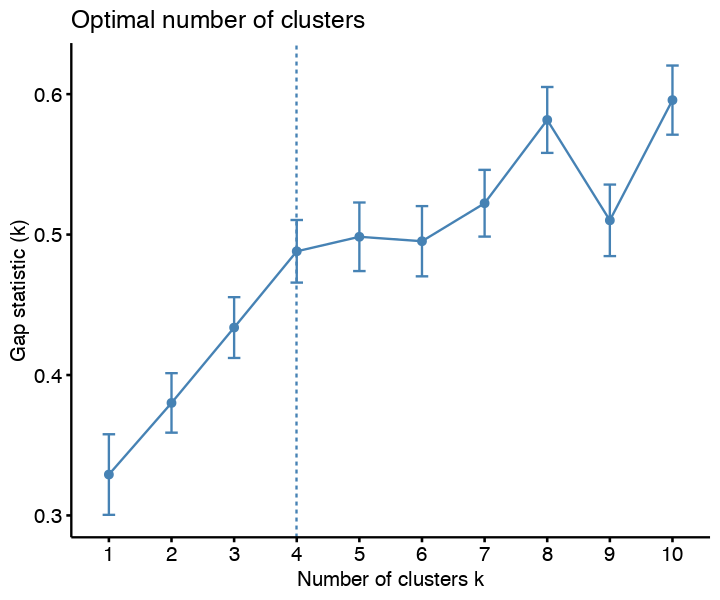

In [163]:
# Determining the optimal number of clusters for kMeans - Returns result of 4  
fviz_nbclust(df_avg_weather_by_country.rescaled, kmeans, method = "gap_stat")

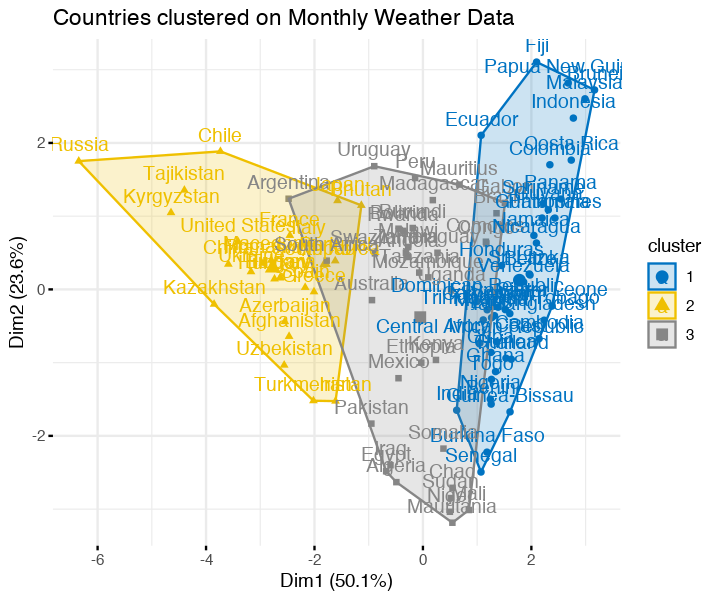

In [165]:
set.seed(123)
km.res <- kmeans(df_avg_weather_by_country.rescaled, 3, nstart = 25)

# Visualize
fviz_cluster(km.res, data = df_avg_weather_by_country.rescaled, palette = "jco", ggtheme = theme_minimal(),main="Countries clustered on Monthly Weather Data")


In [167]:
# Let us look at the centers of each cluster 
# Note that I have transformed the coordinates back to the original scale (Celsius and millimetres) 
# for ease of interpretation
cluster_centres = km.res$centers
cluster_centres[,1:4] = median_temp + (iqr_temp*cluster_centres[,1:4])
cluster_centres[,5:8] = median_rainfall + (iqr_rainfall*cluster_centres[,5:8])
cluster_centres

,AVG_Q1_TEMP,AVG_Q2_TEMP,AVG_Q3_TEMP,AVG_Q4_TEMP,AVG_Q1_RF,AVG_Q2_RF,AVG_Q3_RF,AVG_Q4_RF
1,25.148197,26.82415,25.82249,25.089000,84.89512,178.26033,237.88153,146.98482
2,1.548744,14.84763,19.68912,5.784702,43.22602,64.82413,72.04070,48.73362
3,22.720181,23.55392,23.24406,22.982302,102.92111,59.27574,45.83309,80.22660


In [174]:
# Cluster 1 Countries
names(km.res$cluster[km.res$cluster==1])

[1] "Bangladesh"               "Belize"                  
 [3] "Benin"                    "Brunei"                  
 [5] "Burkina Faso"             "Cambodia"                
 [7] "Cameroon"                 "Central African Republic"
 [9] "Colombia"                 "Costa Rica"              
[11] "Ivory Coast"              "Cuba"                    
[13] "Dominican Republic"       "Ecuador"                 
[15] "El Salvador"              "Fiji"                    
[17] "Ghana"                    "Guatemala"               
[19] "Guinea"                   "Guinea-Bissau"           
[21] "Guyana"                   "Haiti"                   
[23] "Honduras"                 "India"                   
[25] "Indonesia"                "Jamaica"                 
[27] "Laos"                     "Malaysia"                
[29] "Myanmar"                  "Nicaragua"               
[31] "Nigeria"                  "Panama"                  
[33] "Papua New Guinea"         "Philippines"             
[35] "Senegal"                  "Sierra Leone"            
[37] "Sri Lanka"                "Suriname"                
[39] "Thailand"                 "Togo"                    
[41] "Trinidad and Tobago"      "Venezuela"               
[43] "Vietnam"

In [173]:
# Cluster 2 Countries
names(km.res$cluster[km.res$cluster==2])

[1] "Afghanistan"   "Azerbaijan"    "Bhutan"        "Bulgaria"     
 [5] "Chile"         "China"         "France"        "Greece"       
 [9] "Hungary"       "Iran"          "Italy"         "Japan"        
[13] "Kazakhstan"    "South Korea"   "Kyrgyzstan"    "Macedonia"    
[17] "Nepal"         "Portugal"      "Romania"       "Russia"       
[21] "Spain"         "Tajikistan"    "Turkey"        "Turkmenistan" 
[25] "Ukraine"       "United States" "Uzbekistan"

In [176]:
# Cluster 3 Countries
names(km.res$cluster[km.res$cluster==3])

[1] "Algeria"      "Angola"       "Argentina"    "Australia"    "Bolivia"     
 [6] "Brazil"       "Burundi"      "Chad"         "Comoros"      "Congo"       
[11] "Egypt"        "Ethiopia"     "Gabon"        "Iraq"         "Kenya"       
[16] "Madagascar"   "Malawi"       "Mali"         "Mauritania"   "Mauritius"   
[21] "Mexico"       "Mozambique"   "Niger"        "Pakistan"     "Paraguay"    
[26] "Peru"         "Rwanda"       "Somalia"      "South Africa" "Sudan"       
[31] "Swaziland"    "Tanzania"     "Uganda"       "Uruguay"      "Zambia"

# Cluster Analysis: Conclusion

Here are my interpretations for each cluster above:

Cluster 1: Hot all year round and with very heavy summer rainfall (43 countries - Asian countries like Bangladesh, Cambodia, India, Thailand, Vietnam + African and South American)

Cluster 2: Very cold winters with constant low rainfall (27 countries - Europe, US, China, Korea, Japan)

Cluster 3: Warm all year round with good winter rainfall (35 countries - Principally South American and African countries. No European countries and only Asian are Iraq and Pakistan)

NOTE: More work may needed to be done here. For example, countries in the southern hemisphere have their seasons inverted i.e. Summer weather is in December! It may therefore be more appropriate to switch their monthly data columns around so that everything is aligned?

# Rice Yield Cluster Analysis

Let us examine the rice yield in each cluster to see if there is any differences

In [177]:
# Append the cluster id to the master dataframe
df$cluster_id = NA

for (i in 1:3)
 {
  countries_in_cluster = names(km.res$cluster[km.res$cluster==i])
  df$cluster_id[df$COUNTRY %in% countries_in_cluster] = i 
 }


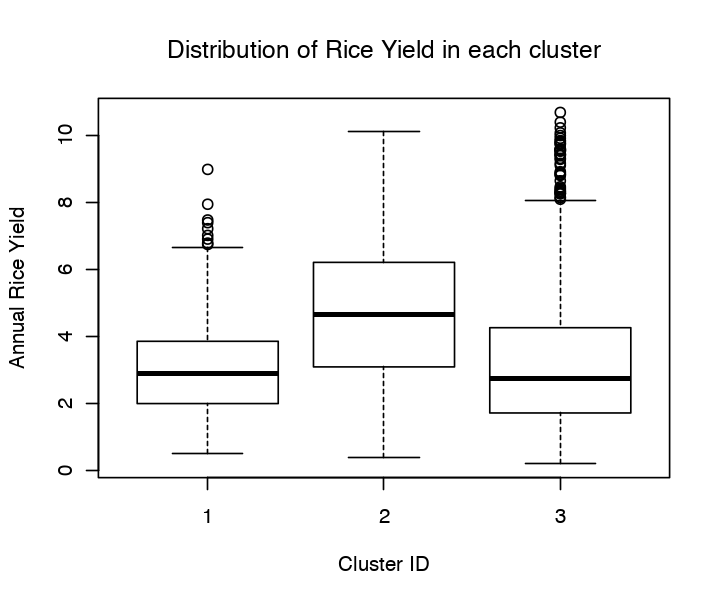

In [178]:
# Change plot size 
options(repr.plot.width=6, repr.plot.height=5)

# Simple boxplot of yield values in each cluster
boxplot(df$YIELD ~ df$cluster_id,xlab='Cluster ID',ylab='Annual Rice Yield',main='Distribution of Rice Yield in each cluster')


Surprisingly perhaps, the cluster with the highest median rice yield is cluster 2. These are the coldest countries with relatively little rainfall. As can be seen in the density plots below, it is bi-modal unlike the other two clusters.

Cluster 1, the hottest and wettest countries do not produce high rice yields! 


Rather than looking at rice yield, which essentially quantifies the efficiency of the rice growing process, let us instead look at the volumes of rice produced in the three clusters.

Below I show the distributions of the annual rice production in the three clusters and perhaps more informatively a  plot showing the mean rice production in these 3 clusters over 25 years.  

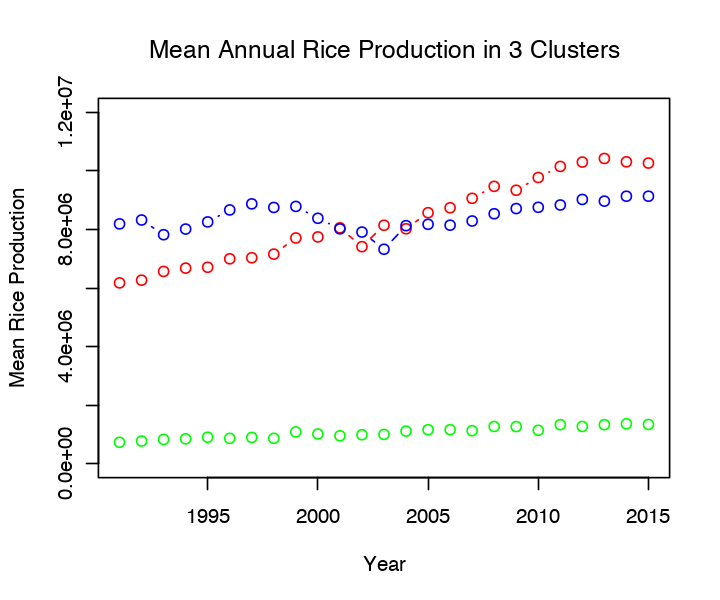

In [191]:
df_production = df
df_production=droplevels(df_production)

# Group by cluster and year and calculate mean rice production
df_avg_production = aggregate(df_production$PRODUCTION, by=list(df_production$cluster_id,df_production$YEAR), FUN=mean)

# Rename columns
names(df_avg_production) = c('cluster_id','YEAR','MEAN_CLUSTER_PRODUCTION')

# Plot Trend over Time chart for mean rice production in each cluster
cl1 = subset(df_avg_production,cluster_id==1)
cl2 = subset(df_avg_production,cluster_id==2)
cl3 = subset(df_avg_production,cluster_id==3)


plot(cl1$YEAR,cl1$MEAN_CLUSTER_PRODUCTION,type='b',col='red',ylim=c(0,12000000),xlab='Year',ylab='Mean Rice Production',main='Mean Annual Rice Production in 3 Clusters')
lines(cl2$YEAR,cl2$MEAN_CLUSTER_PRODUCTION,type='b',col='blue')
lines(cl3$YEAR,cl3$MEAN_CLUSTER_PRODUCTION,type='b',col='green')


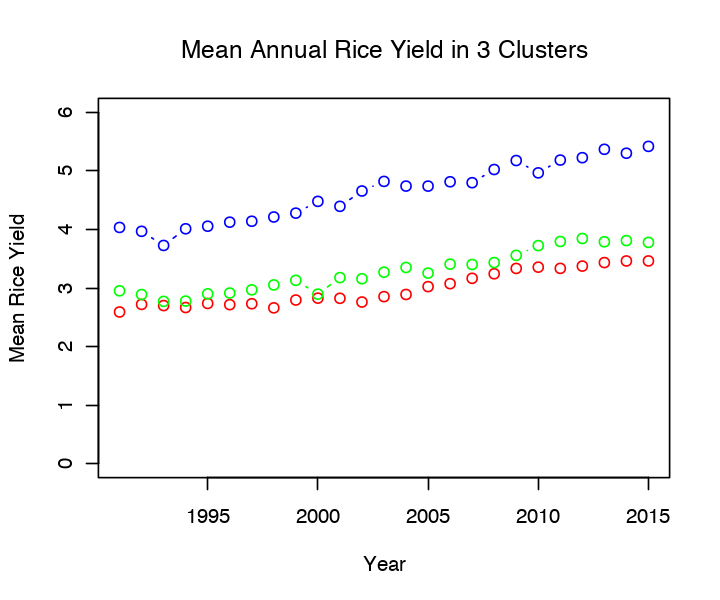

In [187]:
# Group by cluster and year and calculate mean rice yield
df_avg_yield = aggregate(df$YIELD, by=list(df$cluster_id,df$YEAR), FUN=mean)

# Rename columns
names(df_avg_yield) = c('cluster_id','YEAR','MEAN_CLUSTER_YIELD')

# Plot Trend over Time chart for mean rice production in each cluster
cl1 = subset(df_avg_yield,cluster_id==1)
cl2 = subset(df_avg_yield,cluster_id==2)
cl3 = subset(df_avg_yield,cluster_id==3)


plot(cl1$YEAR,cl1$MEAN_CLUSTER_YIELD,type='b',col='red',ylim=c(0,6),xlab='Year',ylab='Mean Rice Yield',main='Mean Annual Rice Yield in 3 Clusters')
lines(cl2$YEAR,cl2$MEAN_CLUSTER_YIELD,type='b',col='blue')
lines(cl3$YEAR,cl3$MEAN_CLUSTER_YIELD,type='b',col='green')


The above two plots are perhaps the most informative. The hot and very wet summers of cluster 3 countries produce the lowest yields, but they still produce the majority of the worlds rice!

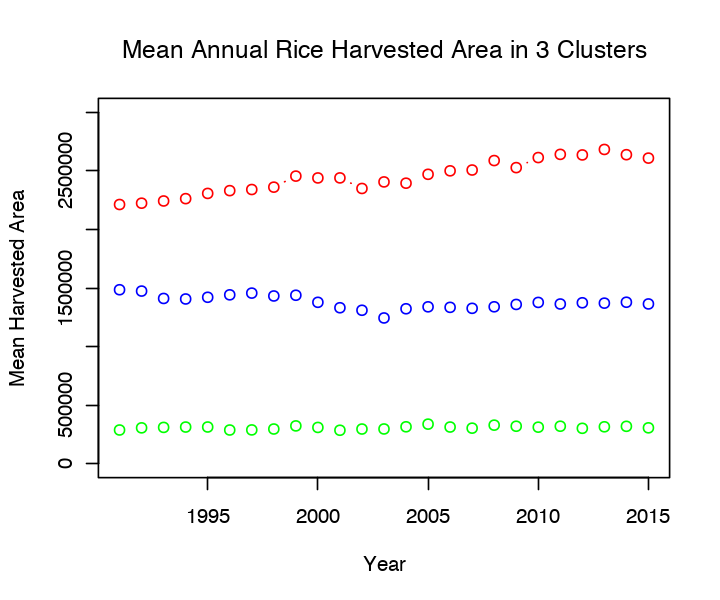

In [189]:
# Group by cluster and year and calculate mean rice yield
df_avg_harvest_area = aggregate(df$HARV_AREA, by=list(df$cluster_id,df$YEAR), FUN=mean)

# Rename columns
names(df_avg_harvest_area) = c('cluster_id','YEAR','MEAN_CLUSTER_HARV_AREA')

# Plot Trend over Time chart for mean rice production in each cluster
cl1 = subset(df_avg_harvest_area,cluster_id==1)
cl2 = subset(df_avg_harvest_area,cluster_id==2)
cl3 = subset(df_avg_harvest_area,cluster_id==3)


plot(cl3$YEAR,cl3$MEAN_CLUSTER_HARV_AREA,type='b',col='green',ylim=c(0,3000000),xlab='Year',ylab='Mean Harvested Area',main='Mean Annual Rice Harvested Area in 3 Clusters')
lines(cl2$YEAR,cl2$MEAN_CLUSTER_HARV_AREA,type='b',col='blue')
lines(cl1$YEAR,cl1$MEAN_CLUSTER_HARV_AREA,type='b',col='red')


# Weather Effects on Rice Yield

Let us leave the clustering behind for now and focus on our main objective. That is, attempting to answer the question:

Does the weather affect the rice yield?

Here we detrend the rice yield to remove any long term systematic changes and attempt to build a model which predicts the detrended rice yield using rescaled weather data. 

Specifically, we calculate:

1. Detrended Rice Yield = Y / sd(Y) where Y = Rice Yield - SMA(Rice Yield)
2. Rescaled Weather Data = ( X_i - mean(X_i) )/sd(X_i)


In [192]:
names(df)

[1] "COUNTRY"      "ISO"          "YEAR"         "LAND_AREA"    "HARV_AREA"   
 [6] "FERT"         "YIELD"        "PRODUCTION"   "AVG_TEMP_JAN" "AVG_TEMP_FEB"
[11] "AVG_TEMP_MAR" "AVG_TEMP_APR" "AVG_TEMP_MAY" "AVG_TEMP_JUN" "AVG_TEMP_JUL"
[16] "AVG_TEMP_AUG" "AVG_TEMP_SEP" "AVG_TEMP_OCT" "AVG_TEMP_NOV" "AVG_TEMP_DEC"
[21] "AVG_RF_JAN"   "AVG_RF_FEB"   "AVG_RF_MAR"   "AVG_RF_APR"   "AVG_RF_MAY"  
[26] "AVG_RF_JUN"   "AVG_RF_JUL"   "AVG_RF_AUG"   "AVG_RF_SEP"   "AVG_RF_OCT"  
[31] "AVG_RF_NOV"   "AVG_RF_DEC"   "AVG_Q1_TEMP"  "AVG_Q2_TEMP"  "AVG_Q3_TEMP" 
[36] "AVG_Q4_TEMP"  "AVG_Q1_RF"    "AVG_Q2_RF"    "AVG_Q3_RF"    "AVG_Q4_RF"   
[41] "cluster_id"

In [193]:
# Create new data frame 
df_detrended = df

# Columns to detrend
column_names = c('YIELD','PRODUCTION','AVG_Q1_TEMP','AVG_Q2_TEMP','AVG_Q3_TEMP','AVG_Q4_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')

# Add detrended columns
for (col_name in column_names)
 {
  detrended_col_name = paste(col_name,'_SMA',sep="")
  df_detrended = get_sma_for_column(df_detrended,newColName=detrended_col_name,colName=col_name,n=5)
}

# Calculate deviations from SMA values
for (col_name in column_names)
 {
  sma_col_name = paste(col_name,'_SMA',sep="")
  deviation_col_name = paste(col_name,'_DEV',sep="")
  df_detrended[deviation_col_name]  = df_detrended[col_name] - df_detrended[sma_col_name]
}

# Add new empty columns to data frame
for (col_name in column_names)
 {
  mean_deviation_col_name = paste(col_name,'_DEV_MEAN',sep="")
  sd_deviation_col_name = paste(col_name,'_DEV_SD',sep="")
  z_deviation_col_name = paste(col_name,'_Z',sep="")
    
  df_detrended[mean_deviation_col_name] = NA
  df_detrended[sd_deviation_col_name] = NA
  df_detrended[z_deviation_col_name] = NA
 }


# Obtain and record mean and standard deviation of deviations for each country
for (country in unique(df_detrended$COUNTRY))
 {
  df_country = subset(df_detrended,COUNTRY==country)
    
  for (col_name in column_names)
   {
    deviation_col_name = paste(col_name,'_DEV',sep="")
    mean_deviation_col_name = paste(col_name,'_DEV_MEAN',sep="")
    sd_deviation_col_name = paste(col_name,'_DEV_SD',sep="")
    
    mean_value = mean(df_country[,deviation_col_name],na.rm=T)
    sd_value = sd(df_country[,deviation_col_name],na.rm=T)
      
    df_detrended[,mean_deviation_col_name][df_detrended$COUNTRY==country] = mean_value
    df_detrended[,sd_deviation_col_name][df_detrended$COUNTRY==country] = sd_value 
   }  
 }
    

# Rescale deviations to get effective Z-Scores for rice yield, production and weather data
for (col_name in column_names)
 {
  deviation_col_name = paste(col_name,'_DEV',sep="")
  mean_deviation_col_name = paste(col_name,'_DEV_MEAN',sep="")
  sd_deviation_col_name = paste(col_name,'_DEV_SD',sep="")
  z_deviation_col_name = paste(col_name,'_Z',sep="")
    
  df_detrended[,z_deviation_col_name] = ( df_detrended[,deviation_col_name] - df_detrended[,mean_deviation_col_name] ) / df_detrended[,sd_deviation_col_name]
 }

# Remove rows with NAs
df_detrended = df_detrended[complete.cases(df_detrended),]
df_detrended=droplevels(df_detrended)


# Create data set for each cluster
df_cluster1 = subset(df_detrended,cluster_id==1)
df_cluster2 = subset(df_detrended,cluster_id==2)
df_cluster3 = subset(df_detrended,cluster_id==3)

# Multiple Linear Regression Model 

We attempt to build regression models that predict the average annual yield based on solely the monthly weather data.

We begin with building a model using ALL the 94 countries in our data set. Later we will build models on each of our individual clusters.

# Correlation: All Countries

In [194]:
library("corrplot")

In [204]:
#weather_features = c('AVG_TEMP_JAN_Z','AVG_TEMP_FEB_Z','AVG_TEMP_MAR_Z','AVG_TEMP_APR_Z','AVG_TEMP_MAY_Z','AVG_TEMP_JUN_Z',
#                     'AVG_TEMP_JUL_Z','AVG_TEMP_AUG_Z','AVG_TEMP_SEP_Z','AVG_TEMP_OCT_Z','AVG_TEMP_NOV_Z','AVG_TEMP_DEC_Z',
#                     'AVG_RF_JAN_Z','AVG_RF_FEB_Z','AVG_RF_MAR_Z','AVG_RF_APR_Z','AVG_RF_MAY_Z','AVG_RF_JUN_Z',
#                     'AVG_RF_JUL_Z','AVG_RF_AUG_Z','AVG_RF_SEP_Z','AVG_RF_OCT_Z','AVG_RF_NOV_Z','AVG_RF_DEC_Z')

#weather_features = c('AVG_TEMP_JAN','AVG_TEMP_FEB','AVG_TEMP_MAR','AVG_TEMP_APR','AVG_TEMP_MAY','AVG_TEMP_JUN',
#                     'AVG_TEMP_JUL','AVG_TEMP_AUG','AVG_TEMP_SEP','AVG_TEMP_OCT','AVG_TEMP_NOV','AVG_TEMP_DEC',
#                     'AVG_RF_JAN','AVG_RF_FEB','AVG_RF_MAR','AVG_RF_APR','AVG_RF_MAY','AVG_RF_JUN',
#                     'AVG_RF_JUL','AVG_RF_AUG','AVG_RF_SEP','AVG_RF_OCT','AVG_RF_NOV','AVG_RF_DEC')

#other_features = c('YEAR','LAND_AREA','HARV_AREA','FERT')

weather_features = c('AVG_Q1_TEMP','AVG_Q2_TEMP','AVG_Q3_TEMP','AVG_Q4_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')

cor(df_detrended[,weather_features])

#corrplot(M, method="color")


,AVG_Q1_TEMP,AVG_Q2_TEMP,AVG_Q3_TEMP,AVG_Q4_TEMP,AVG_Q1_RF,AVG_Q2_RF,AVG_Q3_RF,AVG_Q4_RF
AVG_Q1_TEMP,1.0000000,0.77143068,0.44865733,0.9868454,0.27194042,0.3644336,0.34280601,0.38722111
AVG_Q2_TEMP,0.7714307,1.00000000,0.88167760,0.8239895,-0.03152095,0.2534770,0.39140454,0.18229874
AVG_Q3_TEMP,0.4486573,0.88167760,1.00000000,0.5414842,-0.14643665,0.1500256,0.27238543,0.08345797
AVG_Q4_TEMP,0.9868454,0.82398947,0.54148415,1.0000000,0.25784579,0.3545941,0.33996963,0.37432274
AVG_Q1_RF,0.2719404,-0.03152095,-0.14643665,0.2578458,1.00000000,0.3466801,-0.09737484,0.54243390
AVG_Q2_RF,0.3644336,0.25347700,0.15002562,0.3545941,0.34668012,1.0000000,0.68268549,0.62079183
AVG_Q3_RF,0.3428060,0.39140454,0.27238543,0.3399696,-0.09737484,0.6826855,1.00000000,0.34634219
AVG_Q4_RF,0.3872211,0.18229874,0.08345797,0.3743227,0.54243390,0.6207918,0.34634219,1.00000000


The weather data does show some strong correlation! Removing any highly correlated variables, one could use the any of the following as predictors:

In [203]:
#weather_features = c('AVG_Q1_TEMP','AVG_Q2_TEMP','AVG_Q3_TEMP','AVG_Q4_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')
weather_features = c('AVG_Q1_TEMP','AVG_Q3_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')
cor(df_detrended[,weather_features])


,AVG_Q2_TEMP,AVG_Q4_TEMP,AVG_Q1_RF,AVG_Q2_RF,AVG_Q3_RF,AVG_Q4_RF
AVG_Q2_TEMP,1.00000000,0.8239895,-0.03152095,0.2534770,0.39140454,0.1822987
AVG_Q4_TEMP,0.82398947,1.0000000,0.25784579,0.3545941,0.33996963,0.3743227
AVG_Q1_RF,-0.03152095,0.2578458,1.00000000,0.3466801,-0.09737484,0.5424339
AVG_Q2_RF,0.25347700,0.3545941,0.34668012,1.0000000,0.68268549,0.6207918
AVG_Q3_RF,0.39140454,0.3399696,-0.09737484,0.6826855,1.00000000,0.3463422
AVG_Q4_RF,0.18229874,0.3743227,0.54243390,0.6207918,0.34634219,1.0000000


# Correlation: Cluster 1

In [206]:
weather_features = c('AVG_Q1_TEMP','AVG_Q2_TEMP','AVG_Q3_TEMP','AVG_Q4_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')
cor(df_cluster1[,weather_features])


,AVG_Q1_TEMP,AVG_Q2_TEMP,AVG_Q3_TEMP,AVG_Q4_TEMP,AVG_Q1_RF,AVG_Q2_RF,AVG_Q3_RF,AVG_Q4_RF
AVG_Q1_TEMP,1.00000000,0.48991663,0.087714257,0.86855451,-0.03968624,-0.2095565,-0.176951041,-0.11733471
AVG_Q2_TEMP,0.48991663,1.00000000,0.704871413,0.55270137,-0.51324948,-0.5804659,0.081146672,-0.45856226
AVG_Q3_TEMP,0.08771426,0.70487141,1.000000000,0.39739150,-0.37694606,-0.3080928,0.005906105,-0.17401597
AVG_Q4_TEMP,0.86855451,0.55270137,0.397391503,1.00000000,-0.01710061,-0.2164972,-0.252778150,-0.12314970
AVG_Q1_RF,-0.03968624,-0.51324948,-0.376946058,-0.01710061,1.00000000,0.4952057,-0.278481055,0.54935357
AVG_Q2_RF,-0.20955645,-0.58046593,-0.308092799,-0.21649721,0.49520573,1.0000000,0.155112786,0.47456154
AVG_Q3_RF,-0.17695104,0.08114667,0.005906105,-0.25277815,-0.27848106,0.1551128,1.000000000,-0.01305965
AVG_Q4_RF,-0.11733471,-0.45856226,-0.174015974,-0.12314970,0.54935357,0.4745615,-0.013059652,1.00000000


In [209]:
weather_features = c('AVG_Q2_TEMP','AVG_Q4_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')
weather_features = c('AVG_Q1_TEMP','AVG_Q3_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')
cor(df_cluster1[,weather_features])


,AVG_Q1_TEMP,AVG_Q3_TEMP,AVG_Q1_RF,AVG_Q2_RF,AVG_Q3_RF,AVG_Q4_RF
AVG_Q1_TEMP,1.00000000,0.087714257,-0.03968624,-0.2095565,-0.176951041,-0.11733471
AVG_Q3_TEMP,0.08771426,1.000000000,-0.37694606,-0.3080928,0.005906105,-0.17401597
AVG_Q1_RF,-0.03968624,-0.376946058,1.00000000,0.4952057,-0.278481055,0.54935357
AVG_Q2_RF,-0.20955645,-0.308092799,0.49520573,1.0000000,0.155112786,0.47456154
AVG_Q3_RF,-0.17695104,0.005906105,-0.27848106,0.1551128,1.000000000,-0.01305965
AVG_Q4_RF,-0.11733471,-0.174015974,0.54935357,0.4745615,-0.013059652,1.00000000


# Correlation: Cluster 2 

In [210]:
weather_features = c('AVG_Q1_TEMP','AVG_Q2_TEMP','AVG_Q3_TEMP','AVG_Q4_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')
cor(df_cluster2[,weather_features])


,AVG_Q1_TEMP,AVG_Q2_TEMP,AVG_Q3_TEMP,AVG_Q4_TEMP,AVG_Q1_RF,AVG_Q2_RF,AVG_Q3_RF,AVG_Q4_RF
AVG_Q1_TEMP,1.0000000,0.53267560,0.30532294,0.9470500,0.245708516,0.168702948,0.12809995,0.24738386
AVG_Q2_TEMP,0.5326756,1.00000000,0.89806752,0.6586312,-0.018144035,-0.165225967,-0.06964190,-0.07355894
AVG_Q3_TEMP,0.3053229,0.89806752,1.00000000,0.4753456,0.103719025,-0.192772229,-0.13655304,0.04593376
AVG_Q4_TEMP,0.9470500,0.65863120,0.47534560,1.0000000,0.288218605,0.164758713,0.13578619,0.27466156
AVG_Q1_RF,0.2457085,-0.01814404,0.10371903,0.2882186,1.000000000,-0.009677157,-0.12214508,0.57930988
AVG_Q2_RF,0.1687029,-0.16522597,-0.19277223,0.1647587,-0.009677157,1.000000000,0.85892778,0.17349780
AVG_Q3_RF,0.1280999,-0.06964190,-0.13655304,0.1357862,-0.122145083,0.858927775,1.00000000,0.02427295
AVG_Q4_RF,0.2473839,-0.07355894,0.04593376,0.2746616,0.579309877,0.173497799,0.02427295,1.00000000


In [215]:
weather_features = c('AVG_Q1_TEMP','AVG_Q3_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q4_RF')
weather_features = c('AVG_Q2_TEMP','AVG_Q4_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q4_RF')
weather_features = c('AVG_Q1_TEMP','AVG_Q3_TEMP','AVG_Q1_RF','AVG_Q3_RF','AVG_Q4_RF')
weather_features = c('AVG_Q2_TEMP','AVG_Q4_TEMP','AVG_Q1_RF','AVG_Q3_RF','AVG_Q4_RF')
cor(df_cluster2[,weather_features])


,AVG_Q1_TEMP,AVG_Q3_TEMP,AVG_Q1_RF,AVG_Q3_RF,AVG_Q4_RF
AVG_Q1_TEMP,1.0000000,0.30532294,0.2457085,0.12809995,0.24738386
AVG_Q3_TEMP,0.3053229,1.00000000,0.1037190,-0.13655304,0.04593376
AVG_Q1_RF,0.2457085,0.10371903,1.0000000,-0.12214508,0.57930988
AVG_Q3_RF,0.1280999,-0.13655304,-0.1221451,1.00000000,0.02427295
AVG_Q4_RF,0.2473839,0.04593376,0.5793099,0.02427295,1.00000000


# Correlation: Cluster 3

In [216]:
weather_features = c('AVG_Q1_TEMP','AVG_Q2_TEMP','AVG_Q3_TEMP','AVG_Q4_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')
cor(df_cluster3[,weather_features])


,AVG_Q1_TEMP,AVG_Q2_TEMP,AVG_Q3_TEMP,AVG_Q4_TEMP,AVG_Q1_RF,AVG_Q2_RF,AVG_Q3_RF,AVG_Q4_RF
AVG_Q1_TEMP,1.00000000,-0.01433272,-0.25455813,0.871226182,0.36659928,0.3612143,0.124644620,0.36467109
AVG_Q2_TEMP,-0.01433272,1.00000000,0.94773042,0.348595035,-0.44875691,-0.2140717,0.155554988,-0.42781247
AVG_Q3_TEMP,-0.25455813,0.94773042,1.00000000,0.146130588,-0.49280536,-0.3048213,0.026281770,-0.46472711
AVG_Q4_TEMP,0.87122618,0.34859503,0.14613059,1.000000000,0.22490362,0.1507158,-0.009523599,0.16870211
AVG_Q1_RF,0.36659928,-0.44875691,-0.49280536,0.224903619,1.00000000,0.5080564,-0.047168571,0.64457755
AVG_Q2_RF,0.36121426,-0.21407169,-0.30482134,0.150715759,0.50805641,1.0000000,0.449556374,0.64409536
AVG_Q3_RF,0.12464462,0.15555499,0.02628177,-0.009523599,-0.04716857,0.4495564,1.000000000,0.09980023
AVG_Q4_RF,0.36467109,-0.42781247,-0.46472711,0.168702105,0.64457755,0.6440954,0.099800230,1.00000000


In [218]:
weather_features = c('AVG_Q1_TEMP','AVG_Q3_TEMP','AVG_Q1_RF','AVG_Q2_RF','AVG_Q3_RF','AVG_Q4_RF')
cor(df_cluster3[,weather_features])


,AVG_Q1_TEMP,AVG_Q3_TEMP,AVG_Q1_RF,AVG_Q2_RF,AVG_Q3_RF,AVG_Q4_RF
AVG_Q1_TEMP,1.0000000,-0.25455813,0.36659928,0.3612143,0.12464462,0.36467109
AVG_Q3_TEMP,-0.2545581,1.00000000,-0.49280536,-0.3048213,0.02628177,-0.46472711
AVG_Q1_RF,0.3665993,-0.49280536,1.00000000,0.5080564,-0.04716857,0.64457755
AVG_Q2_RF,0.3612143,-0.30482134,0.50805641,1.0000000,0.44955637,0.64409536
AVG_Q3_RF,0.1246446,0.02628177,-0.04716857,0.4495564,1.00000000,0.09980023
AVG_Q4_RF,0.3646711,-0.46472711,0.64457755,0.6440954,0.09980023,1.00000000


In [62]:
# Just Weather data + YEAR
#FitAll = lm(YIELD ~ YEAR + factor(COUNTRY) + AVG_TEMP_JAN+AVG_TEMP_JUL+AVG_RF_JAN+AVG_RF_APR+AVG_RF_JUL+AVG_RF_OCT, data=df_detrended)

# COUNTRY + YEAR + WEATHER
#FitAll = lm(YIELD ~ AVG_TEMP_JAN+AVG_TEMP_JUL+AVG_RF_JAN+AVG_RF_APR+AVG_RF_JUL+AVG_RF_OCT, data=df_detrended)

#FitAll = lm(YIELD ~ YEAR+factor(COUNTRY)+HARV_AREA+FERT+AVG_TEMP_JAN+AVG_TEMP_JUL+AVG_RF_JAN+AVG_RF_APR+AVG_RF_JUL+AVG_RF_OCT, data=df_detrended)

#step(FitAll,direction='backward')


In [83]:
#model = lm(YIELD ~ YEAR+factor(COUNTRY)+HARV_AREA+FERT+AVG_TEMP_JAN+AVG_TEMP_JUL+AVG_RF_JAN+AVG_RF_APR+AVG_RF_JUL+AVG_RF_OCT, data = df_cluster2)
model = lm(YIELD ~ AVG_TEMP_JAN+AVG_TEMP_JUL+AVG_RF_JAN+AVG_RF_APR+AVG_RF_JUL+AVG_RF_OCT, data = df_detrended)
summary(model)



Call:
lm(formula = YIELD ~ AVG_TEMP_JAN + AVG_TEMP_JUL + AVG_RF_JAN + 
    AVG_RF_APR + AVG_RF_JUL + AVG_RF_OCT, data = df_detrended)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4807 -1.3495 -0.2401  1.1433  6.9156 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.7741552  0.1930390  29.912  < 2e-16 ***
AVG_TEMP_JAN -0.0466896  0.0037287 -12.522  < 2e-16 ***
AVG_TEMP_JUL -0.0619865  0.0079505  -7.797 9.78e-15 ***
AVG_RF_JAN   -0.0008917  0.0004761  -1.873   0.0612 .  
AVG_RF_APR   -0.0001346  0.0005733  -0.235   0.8144    
AVG_RF_JUL   -0.0005277  0.0003512  -1.503   0.1331    
AVG_RF_OCT    0.0010539  0.0004261   2.473   0.0135 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.764 on 2177 degrees of freedom
Multiple R-squared:  0.129,	Adjusted R-squared:  0.1266 
F-statistic: 53.75 on 6 and 2177 DF,  p-value: < 2.2e-16


# All countries

In [94]:
FitAll = lm(YIELD_Z ~ AVG_TEMP_JAN_Z+AVG_TEMP_FEB_Z+AVG_TEMP_MAR_Z+AVG_TEMP_APR_Z+AVG_TEMP_MAY_Z+AVG_TEMP_JUN_Z+AVG_TEMP_JUL_Z+AVG_TEMP_AUG_Z+AVG_TEMP_SEP_Z+AVG_TEMP_OCT_Z+AVG_TEMP_NOV_Z+AVG_TEMP_DEC_Z+AVG_RF_JAN_Z+AVG_RF_FEB_Z+AVG_RF_MAR_Z+AVG_RF_APR_Z+AVG_RF_MAY_Z+AVG_RF_JUN_Z+AVG_RF_JUL_Z+AVG_RF_AUG_Z+AVG_RF_SEP_Z+AVG_RF_OCT_Z+AVG_RF_NOV_Z+AVG_RF_DEC_Z, data=df_detrended)
step(FitAll,direction='backward')


Start:  AIC=-89.37
YIELD_Z ~ AVG_TEMP_JAN_Z + AVG_TEMP_FEB_Z + AVG_TEMP_MAR_Z + 
    AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z + AVG_TEMP_JUN_Z + AVG_TEMP_JUL_Z + 
    AVG_TEMP_AUG_Z + AVG_TEMP_SEP_Z + AVG_TEMP_OCT_Z + AVG_TEMP_NOV_Z + 
    AVG_TEMP_DEC_Z + AVG_RF_JAN_Z + AVG_RF_FEB_Z + AVG_RF_MAR_Z + 
    AVG_RF_APR_Z + AVG_RF_MAY_Z + AVG_RF_JUN_Z + AVG_RF_JUL_Z + 
    AVG_RF_AUG_Z + AVG_RF_SEP_Z + AVG_RF_OCT_Z + AVG_RF_NOV_Z + 
    AVG_RF_DEC_Z

                 Df Sum of Sq    RSS     AIC
- AVG_RF_JAN_Z    1    0.0000 2049.0 -91.372
- AVG_RF_SEP_Z    1    0.0117 2049.0 -91.360
- AVG_RF_JUN_Z    1    0.0663 2049.1 -91.302
- AVG_TEMP_JUN_Z  1    0.1283 2049.1 -91.236
- AVG_RF_JUL_Z    1    0.1319 2049.1 -91.232
- AVG_TEMP_OCT_Z  1    0.1346 2049.1 -91.229
- AVG_RF_OCT_Z    1    0.1475 2049.1 -91.215
- AVG_RF_FEB_Z    1    0.1507 2049.1 -91.212
- AVG_TEMP_SEP_Z  1    0.1623 2049.1 -91.199
- AVG_RF_AUG_Z    1    0.1854 2049.2 -91.175
- AVG_TEMP_AUG_Z  1    0.2001 2049.2 -91.159
- AVG_TEMP_MAR_Z  


Call:
lm(formula = YIELD_Z ~ AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z + AVG_TEMP_NOV_Z + 
    AVG_RF_MAR_Z + AVG_RF_APR_Z + AVG_RF_NOV_Z + AVG_RF_DEC_Z, 
    data = df_detrended)

Coefficients:
   (Intercept)  AVG_TEMP_APR_Z  AVG_TEMP_MAY_Z  AVG_TEMP_NOV_Z    AVG_RF_MAR_Z  
     1.350e-17       6.421e-02      -5.577e-02      -4.842e-02       3.340e-02  
  AVG_RF_APR_Z    AVG_RF_NOV_Z    AVG_RF_DEC_Z  
     4.865e-02      -5.705e-02       3.372e-02  


In [95]:
model = lm(formula = YIELD_Z ~ AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z + AVG_TEMP_NOV_Z + 
    AVG_RF_MAR_Z + AVG_RF_APR_Z + AVG_RF_NOV_Z + AVG_RF_DEC_Z, data = df_detrended)
summary(model)


Call:
lm(formula = YIELD_Z ~ AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z + AVG_TEMP_NOV_Z + 
    AVG_RF_MAR_Z + AVG_RF_APR_Z + AVG_RF_NOV_Z + AVG_RF_DEC_Z, 
    data = df_detrended)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1330 -0.5591  0.0451  0.5773  3.5443 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)     1.350e-17  2.079e-02   0.000  1.00000   
AVG_TEMP_APR_Z  6.421e-02  2.431e-02   2.641  0.00832 **
AVG_TEMP_MAY_Z -5.577e-02  2.381e-02  -2.342  0.01925 * 
AVG_TEMP_NOV_Z -4.842e-02  2.181e-02  -2.220  0.02649 * 
AVG_RF_MAR_Z    3.340e-02  2.176e-02   1.535  0.12489   
AVG_RF_APR_Z    4.865e-02  2.207e-02   2.204  0.02762 * 
AVG_RF_NOV_Z   -5.705e-02  2.166e-02  -2.634  0.00851 **
AVG_RF_DEC_Z    3.372e-02  2.162e-02   1.560  0.11901   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9714 on 2176 degrees of freedom
Multiple R-squared:  0.0129,	Adjusted R-squared:  0.009724 
F-statistic: 4.062 o

In [97]:
model = lm(formula = YIELD_Z ~ AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z + AVG_TEMP_NOV_Z + 
    + AVG_RF_APR_Z + AVG_RF_NOV_Z, data = df_detrended)
summary(model)


Call:
lm(formula = YIELD_Z ~ AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z + AVG_TEMP_NOV_Z + 
    +AVG_RF_APR_Z + AVG_RF_NOV_Z, data = df_detrended)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1185 -0.5597  0.0483  0.5712  3.5514 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)  
(Intercept)     1.455e-17  2.080e-02   0.000   1.0000  
AVG_TEMP_APR_Z  6.037e-02  2.415e-02   2.500   0.0125 *
AVG_TEMP_MAY_Z -5.745e-02  2.376e-02  -2.418   0.0157 *
AVG_TEMP_NOV_Z -4.813e-02  2.171e-02  -2.217   0.0267 *
AVG_RF_APR_Z    5.052e-02  2.203e-02   2.293   0.0220 *
AVG_RF_NOV_Z   -5.380e-02  2.146e-02  -2.507   0.0123 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.972 on 2178 degrees of freedom
Multiple R-squared:  0.01076,	Adjusted R-squared:  0.008489 
F-statistic: 4.738 on 5 and 2178 DF,  p-value: 0.0002617


# Cluster 1: Very cold winters with constant low rainfall 

In [148]:
# Create data set for each cluster
df_cluster1 = subset(df_detrended,cluster_id==1)
df_cluster2 = subset(df_detrended,cluster_id==2)
df_cluster3 = subset(df_detrended,cluster_id==3)

In [99]:
cluster_centres

,AVG_TEMP_JAN,AVG_TEMP_FEB,AVG_TEMP_MAR,AVG_TEMP_APR,AVG_TEMP_MAY,AVG_TEMP_JUN,AVG_TEMP_JUL,AVG_TEMP_AUG,AVG_TEMP_SEP,AVG_TEMP_OCT,⋯,AVG_RF_MAR,AVG_RF_APR,AVG_RF_MAY,AVG_RF_JUN,AVG_RF_JUL,AVG_RF_AUG,AVG_RF_SEP,AVG_RF_OCT,AVG_RF_NOV,AVG_RF_DEC
1,-0.9139926,0.5358739,5.024352,10.34044,15.06090,19.14154,21.35687,20.93695,16.77355,11.37797,⋯,47.08572,55.26622,65.30166,73.90451,81.90675,71.98635,62.22901,52.70039,47.36561,46.13487
2,22.0704502,22.7675632,23.530497,23.85335,23.66198,23.05258,22.60924,23.11586,23.78542,23.88947,⋯,116.27366,92.40203,67.47556,45.38880,47.17030,49.98709,52.97540,70.15781,85.45955,102.15956
3,24.0359879,25.1488650,26.427381,27.23361,27.16674,26.63539,26.08088,25.93994,26.02402,25.98844,⋯,80.58824,115.69618,193.18361,218.55141,238.54135,257.61324,234.19366,203.93025,133.10986,98.25473


In [102]:
FitAll = lm(YIELD_Z ~ AVG_TEMP_JAN_Z+AVG_TEMP_FEB_Z+AVG_TEMP_MAR_Z+AVG_TEMP_APR_Z+AVG_TEMP_MAY_Z+AVG_TEMP_JUN_Z+AVG_TEMP_JUL_Z+AVG_TEMP_AUG_Z+AVG_TEMP_SEP_Z+AVG_TEMP_OCT_Z+AVG_TEMP_NOV_Z+AVG_TEMP_DEC_Z+AVG_RF_JAN_Z+AVG_RF_FEB_Z+AVG_RF_MAR_Z+AVG_RF_APR_Z+AVG_RF_MAY_Z+AVG_RF_JUN_Z+AVG_RF_JUL_Z+AVG_RF_AUG_Z+AVG_RF_SEP_Z+AVG_RF_OCT_Z+AVG_RF_NOV_Z+AVG_RF_DEC_Z, data=df_cluster1)
step(FitAll,direction='backward')


Start:  AIC=-1
YIELD_Z ~ AVG_TEMP_JAN_Z + AVG_TEMP_FEB_Z + AVG_TEMP_MAR_Z + 
    AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z + AVG_TEMP_JUN_Z + AVG_TEMP_JUL_Z + 
    AVG_TEMP_AUG_Z + AVG_TEMP_SEP_Z + AVG_TEMP_OCT_Z + AVG_TEMP_NOV_Z + 
    AVG_TEMP_DEC_Z + AVG_RF_JAN_Z + AVG_RF_FEB_Z + AVG_RF_MAR_Z + 
    AVG_RF_APR_Z + AVG_RF_MAY_Z + AVG_RF_JUN_Z + AVG_RF_JUL_Z + 
    AVG_RF_AUG_Z + AVG_RF_SEP_Z + AVG_RF_OCT_Z + AVG_RF_NOV_Z + 
    AVG_RF_DEC_Z

                 Df Sum of Sq    RSS      AIC
- AVG_RF_JUN_Z    1    0.0026 518.23 -2.99758
- AVG_RF_NOV_Z    1    0.0082 518.23 -2.99148
- AVG_TEMP_APR_Z  1    0.0125 518.24 -2.98676
- AVG_TEMP_JAN_Z  1    0.0164 518.24 -2.98244
- AVG_TEMP_SEP_Z  1    0.0169 518.24 -2.98196
- AVG_TEMP_AUG_Z  1    0.0344 518.26 -2.96272
- AVG_TEMP_OCT_Z  1    0.0797 518.31 -2.91324
- AVG_RF_FEB_Z    1    0.0956 518.32 -2.89584
- AVG_TEMP_MAR_Z  1    0.2186 518.44 -2.76125
- AVG_TEMP_FEB_Z  1    0.2362 518.46 -2.74203
- AVG_RF_SEP_Z    1    0.2823 518.51 -2.69161
- AVG_RF_J


Call:
lm(formula = YIELD_Z ~ AVG_TEMP_JUL_Z + AVG_TEMP_NOV_Z + AVG_RF_JAN_Z + 
    AVG_RF_APR_Z + AVG_RF_AUG_Z, data = df_cluster1)

Coefficients:
   (Intercept)  AVG_TEMP_JUL_Z  AVG_TEMP_NOV_Z    AVG_RF_JAN_Z    AVG_RF_APR_Z  
     3.180e-17       1.007e-01      -7.209e-02       6.426e-02       7.871e-02  
  AVG_RF_AUG_Z  
    -7.007e-02  


In [103]:
model = lm(YIELD_Z ~ AVG_TEMP_JUL_Z + AVG_TEMP_NOV_Z + AVG_RF_JAN_Z + AVG_RF_APR_Z + AVG_RF_AUG_Z, data=df_cluster1)
summary(model)



Call:
lm(formula = YIELD_Z ~ AVG_TEMP_JUL_Z + AVG_TEMP_NOV_Z + AVG_RF_JAN_Z + 
    AVG_RF_APR_Z + AVG_RF_AUG_Z, data = df_cluster1)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4960 -0.5887  0.0058  0.6693  3.4572 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)  
(Intercept)     3.180e-17  4.061e-02   0.000   1.0000  
AVG_TEMP_JUL_Z  1.007e-01  4.175e-02   2.412   0.0162 *
AVG_TEMP_NOV_Z -7.209e-02  4.181e-02  -1.724   0.0852 .
AVG_RF_JAN_Z    6.426e-02  4.174e-02   1.539   0.1243  
AVG_RF_APR_Z    7.871e-02  4.197e-02   1.876   0.0612 .
AVG_RF_AUG_Z   -7.007e-02  4.169e-02  -1.681   0.0934 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9669 on 561 degrees of freedom
Multiple R-squared:  0.02871,	Adjusted R-squared:  0.02005 
F-statistic: 3.316 on 5 and 561 DF,  p-value: 0.005825


In [107]:
model = lm(YIELD_Z ~ AVG_TEMP_JUL_Z, data=df_cluster1)
summary(model)


Call:
lm(formula = YIELD_Z ~ AVG_TEMP_JUL_Z, data = df_cluster1)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5714 -0.6196  0.0063  0.6633  3.5443 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)  
(Intercept)    3.525e-17  4.088e-02   0.000   1.0000  
AVG_TEMP_JUL_Z 9.337e-02  4.189e-02   2.229   0.0262 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9734 on 565 degrees of freedom
Multiple R-squared:  0.008719,	Adjusted R-squared:  0.006964 
F-statistic: 4.969 on 1 and 565 DF,  p-value: 0.02619


# Cluster 2: Warm all year round with good winter rainfall

In [108]:
cluster_centres

,AVG_TEMP_JAN,AVG_TEMP_FEB,AVG_TEMP_MAR,AVG_TEMP_APR,AVG_TEMP_MAY,AVG_TEMP_JUN,AVG_TEMP_JUL,AVG_TEMP_AUG,AVG_TEMP_SEP,AVG_TEMP_OCT,⋯,AVG_RF_MAR,AVG_RF_APR,AVG_RF_MAY,AVG_RF_JUN,AVG_RF_JUL,AVG_RF_AUG,AVG_RF_SEP,AVG_RF_OCT,AVG_RF_NOV,AVG_RF_DEC
1,-0.9139926,0.5358739,5.024352,10.34044,15.06090,19.14154,21.35687,20.93695,16.77355,11.37797,⋯,47.08572,55.26622,65.30166,73.90451,81.90675,71.98635,62.22901,52.70039,47.36561,46.13487
2,22.0704502,22.7675632,23.530497,23.85335,23.66198,23.05258,22.60924,23.11586,23.78542,23.88947,⋯,116.27366,92.40203,67.47556,45.38880,47.17030,49.98709,52.97540,70.15781,85.45955,102.15956
3,24.0359879,25.1488650,26.427381,27.23361,27.16674,26.63539,26.08088,25.93994,26.02402,25.98844,⋯,80.58824,115.69618,193.18361,218.55141,238.54135,257.61324,234.19366,203.93025,133.10986,98.25473


In [109]:
FitAll = lm(YIELD_Z ~ AVG_TEMP_JAN_Z+AVG_TEMP_FEB_Z+AVG_TEMP_MAR_Z+AVG_TEMP_APR_Z+AVG_TEMP_MAY_Z+AVG_TEMP_JUN_Z+AVG_TEMP_JUL_Z+AVG_TEMP_AUG_Z+AVG_TEMP_SEP_Z+AVG_TEMP_OCT_Z+AVG_TEMP_NOV_Z+AVG_TEMP_DEC_Z+AVG_RF_JAN_Z+AVG_RF_FEB_Z+AVG_RF_MAR_Z+AVG_RF_APR_Z+AVG_RF_MAY_Z+AVG_RF_JUN_Z+AVG_RF_JUL_Z+AVG_RF_AUG_Z+AVG_RF_SEP_Z+AVG_RF_OCT_Z+AVG_RF_NOV_Z+AVG_RF_DEC_Z, data=df_cluster2)
step(FitAll,direction='backward')


Start:  AIC=-29.48
YIELD_Z ~ AVG_TEMP_JAN_Z + AVG_TEMP_FEB_Z + AVG_TEMP_MAR_Z + 
    AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z + AVG_TEMP_JUN_Z + AVG_TEMP_JUL_Z + 
    AVG_TEMP_AUG_Z + AVG_TEMP_SEP_Z + AVG_TEMP_OCT_Z + AVG_TEMP_NOV_Z + 
    AVG_TEMP_DEC_Z + AVG_RF_JAN_Z + AVG_RF_FEB_Z + AVG_RF_MAR_Z + 
    AVG_RF_APR_Z + AVG_RF_MAY_Z + AVG_RF_JUN_Z + AVG_RF_JUL_Z + 
    AVG_RF_AUG_Z + AVG_RF_SEP_Z + AVG_RF_OCT_Z + AVG_RF_NOV_Z + 
    AVG_RF_DEC_Z

                 Df Sum of Sq    RSS     AIC
- AVG_TEMP_MAY_Z  1    0.0025 680.56 -31.474
- AVG_TEMP_FEB_Z  1    0.0063 680.56 -31.470
- AVG_TEMP_JUN_Z  1    0.0079 680.57 -31.468
- AVG_RF_JAN_Z    1    0.0338 680.59 -31.439
- AVG_RF_SEP_Z    1    0.1194 680.68 -31.344
- AVG_TEMP_OCT_Z  1    0.1350 680.69 -31.327
- AVG_RF_AUG_Z    1    0.2666 680.82 -31.181
- AVG_TEMP_JAN_Z  1    0.3064 680.86 -31.137
- AVG_RF_FEB_Z    1    0.3484 680.91 -31.090
- AVG_TEMP_DEC_Z  1    0.4612 681.02 -30.965
- AVG_TEMP_NOV_Z  1    0.7476 681.31 -30.647
- AVG_TEMP_AUG_Z  


Call:
lm(formula = YIELD_Z ~ AVG_TEMP_MAR_Z + AVG_TEMP_APR_Z + AVG_TEMP_AUG_Z + 
    AVG_TEMP_SEP_Z + AVG_RF_MAR_Z + AVG_RF_APR_Z + AVG_RF_MAY_Z + 
    AVG_RF_NOV_Z + AVG_RF_DEC_Z, data = df_cluster2)

Coefficients:
   (Intercept)  AVG_TEMP_MAR_Z  AVG_TEMP_APR_Z  AVG_TEMP_AUG_Z  AVG_TEMP_SEP_Z  
     2.754e-17      -5.804e-02       8.863e-02      -6.555e-02       7.196e-02  
  AVG_RF_MAR_Z    AVG_RF_APR_Z    AVG_RF_MAY_Z    AVG_RF_NOV_Z    AVG_RF_DEC_Z  
     9.271e-02       6.286e-02      -8.682e-02      -1.082e-01       1.107e-01  


In [110]:
model = lm(YIELD_Z ~ AVG_TEMP_MAR_Z + AVG_TEMP_APR_Z + AVG_TEMP_AUG_Z + AVG_TEMP_SEP_Z + AVG_RF_MAR_Z + AVG_RF_APR_Z + AVG_RF_MAY_Z + AVG_RF_NOV_Z + AVG_RF_DEC_Z, data=df_cluster2)
summary(model)



Call:
lm(formula = YIELD_Z ~ AVG_TEMP_MAR_Z + AVG_TEMP_APR_Z + AVG_TEMP_AUG_Z + 
    AVG_TEMP_SEP_Z + AVG_RF_MAR_Z + AVG_RF_APR_Z + AVG_RF_MAY_Z + 
    AVG_RF_NOV_Z + AVG_RF_DEC_Z, data = df_cluster2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1945 -0.4511  0.0778  0.5300  3.4617 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)     2.754e-17  3.493e-02   0.000  1.00000   
AVG_TEMP_MAR_Z -5.804e-02  3.975e-02  -1.460  0.14467   
AVG_TEMP_APR_Z  8.863e-02  4.064e-02   2.181  0.02950 * 
AVG_TEMP_AUG_Z -6.555e-02  3.788e-02  -1.731  0.08395 . 
AVG_TEMP_SEP_Z  7.196e-02  3.785e-02   1.901  0.05770 . 
AVG_RF_MAR_Z    9.271e-02  3.703e-02   2.504  0.01251 * 
AVG_RF_APR_Z    6.286e-02  3.671e-02   1.712  0.08723 . 
AVG_RF_MAY_Z   -8.682e-02  3.622e-02  -2.397  0.01676 * 
AVG_RF_NOV_Z   -1.082e-01  3.731e-02  -2.901  0.00383 **
AVG_RF_DEC_Z    1.107e-01  3.708e-02   2.985  0.00292 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘

In [121]:
model = lm(YIELD_Z ~ AVG_RF_MAR_Z + AVG_RF_MAY_Z + AVG_RF_NOV_Z + AVG_RF_DEC_Z, data=df_cluster2)
summary(model)



Call:
lm(formula = YIELD_Z ~ AVG_RF_MAR_Z + AVG_RF_MAY_Z + AVG_RF_NOV_Z + 
    AVG_RF_DEC_Z, data = df_cluster2)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3657 -0.4863  0.0945  0.5423  3.2951 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   3.216e-17  3.510e-02   0.000  1.00000   
AVG_RF_MAR_Z  8.840e-02  3.604e-02   2.453  0.01440 * 
AVG_RF_MAY_Z -8.201e-02  3.614e-02  -2.269  0.02354 * 
AVG_RF_NOV_Z -9.922e-02  3.700e-02  -2.682  0.00749 **
AVG_RF_DEC_Z  1.073e-01  3.703e-02   2.897  0.00387 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9651 on 751 degrees of freedom
Multiple R-squared:  0.02842,	Adjusted R-squared:  0.02324 
F-statistic: 5.492 on 4 and 751 DF,  p-value: 0.0002321


# Cluster 3: Hot all year round and with very heavy summer rainfall

In [122]:
FitAll = lm(YIELD_Z ~ AVG_TEMP_JAN_Z+AVG_TEMP_FEB_Z+AVG_TEMP_MAR_Z+AVG_TEMP_APR_Z+AVG_TEMP_MAY_Z+AVG_TEMP_JUN_Z+AVG_TEMP_JUL_Z+AVG_TEMP_AUG_Z+AVG_TEMP_SEP_Z+AVG_TEMP_OCT_Z+AVG_TEMP_NOV_Z+AVG_TEMP_DEC_Z+AVG_RF_JAN_Z+AVG_RF_FEB_Z+AVG_RF_MAR_Z+AVG_RF_APR_Z+AVG_RF_MAY_Z+AVG_RF_JUN_Z+AVG_RF_JUL_Z+AVG_RF_AUG_Z+AVG_RF_SEP_Z+AVG_RF_OCT_Z+AVG_RF_NOV_Z+AVG_RF_DEC_Z, data=df_cluster3)
step(FitAll,direction='backward')


Start:  AIC=-23.62
YIELD_Z ~ AVG_TEMP_JAN_Z + AVG_TEMP_FEB_Z + AVG_TEMP_MAR_Z + 
    AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z + AVG_TEMP_JUN_Z + AVG_TEMP_JUL_Z + 
    AVG_TEMP_AUG_Z + AVG_TEMP_SEP_Z + AVG_TEMP_OCT_Z + AVG_TEMP_NOV_Z + 
    AVG_TEMP_DEC_Z + AVG_RF_JAN_Z + AVG_RF_FEB_Z + AVG_RF_MAR_Z + 
    AVG_RF_APR_Z + AVG_RF_MAY_Z + AVG_RF_JUN_Z + AVG_RF_JUL_Z + 
    AVG_RF_AUG_Z + AVG_RF_SEP_Z + AVG_RF_OCT_Z + AVG_RF_NOV_Z + 
    AVG_RF_DEC_Z

                 Df Sum of Sq    RSS     AIC
- AVG_RF_FEB_Z    1    0.0000 790.44 -25.616
- AVG_TEMP_FEB_Z  1    0.0048 790.45 -25.611
- AVG_RF_SEP_Z    1    0.0071 790.45 -25.608
- AVG_TEMP_JAN_Z  1    0.0118 790.45 -25.603
- AVG_RF_AUG_Z    1    0.0119 790.45 -25.603
- AVG_RF_DEC_Z    1    0.0135 790.46 -25.602
- AVG_RF_JUN_Z    1    0.0403 790.48 -25.572
- AVG_RF_MAR_Z    1    0.0504 790.49 -25.561
- AVG_RF_JAN_Z    1    0.1997 790.64 -25.399
- AVG_RF_NOV_Z    1    0.2508 790.69 -25.343
- AVG_TEMP_DEC_Z  1    0.5508 790.99 -25.017
- AVG_RF_OCT_Z    


Call:
lm(formula = YIELD_Z ~ AVG_TEMP_MAR_Z + AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z + 
    AVG_TEMP_JUN_Z + AVG_TEMP_OCT_Z + AVG_RF_MAY_Z, data = df_cluster3)

Coefficients:
   (Intercept)  AVG_TEMP_MAR_Z  AVG_TEMP_APR_Z  AVG_TEMP_MAY_Z  AVG_TEMP_JUN_Z  
     2.706e-17      -6.599e-02       1.359e-01      -7.310e-02      -5.825e-02  
AVG_TEMP_OCT_Z    AVG_RF_MAY_Z  
    -7.340e-02       5.998e-02  


In [132]:
model = lm(YIELD_Z ~ AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z, data=df_cluster3)
summary(model)



Call:
lm(formula = YIELD_Z ~ AVG_TEMP_APR_Z + AVG_TEMP_MAY_Z, data = df_cluster3)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0757 -0.5807  0.0041  0.5560  3.3866 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     2.866e-17  3.307e-02   0.000 1.000000    
AVG_TEMP_APR_Z  1.047e-01  4.130e-02   2.534 0.011457 *  
AVG_TEMP_MAY_Z -1.462e-01  4.130e-02  -3.540 0.000422 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9703 on 858 degrees of freedom
Multiple R-squared:  0.01483,	Adjusted R-squared:  0.01253 
F-statistic: 6.458 on 2 and 858 DF,  p-value: 0.001645


# Classification of Rice Yield

In this section we shall investigate if the weather for the year can be used to infer whether the rice yield is above or below trend. We will first establish a benchmark model and then build a random forest model. 

In [187]:
# Let us begin by removing rows with NULL columns (We lose 4 rows for every country!)
df_detrended = df_detrended[complete.cases(df_detrended),]

In [267]:
# Now we need to create a target column with values "Above" and "Below" 
# (as in the yield for that year was above expectations or below expectations)

df_detrended$target = sign(df_detrended$YIELD_Z)
df_detrended[df_detrended$target==1 | df_detrended$target==0,'target'] = 'Above'
df_detrended[df_detrended$target==-1,'target'] = 'Below'

# Make target variable a factor
df_detrended$target = factor(df_detrended$target)

# Create data set for each cluster
df_cluster1 = subset(df_detrended,cluster_id==1)
df_cluster2 = subset(df_detrended,cluster_id==2)
df_cluster3 = subset(df_detrended,cluster_id==3)


In [268]:
# Benchmark Model
table(df_detrended$target)


Above Below 
 1152  1032 

# Random Forest Model on ALL countries

We shall train a random forest model on all our 94 countries. We first to extract the subset of data that we need to train our model and then split this data set into training and test sets

In [283]:
# Model features
target_variable = 'target'
attribute_variables = c()
#attribute_variables = c('COUNTRY','YEAR')
attribute_variables = c('COUNTRY','YEAR','LAND_AREA','HARV_AREA','FERT')

#weather_features = c('AVG_TEMP_JAN_Z','AVG_TEMP_FEB_Z','AVG_TEMP_MAR_Z','AVG_TEMP_APR_Z','AVG_TEMP_MAY_Z','AVG_TEMP_JUN_Z',
#                     'AVG_TEMP_JUL_Z','AVG_TEMP_AUG_Z','AVG_TEMP_SEP_Z','AVG_TEMP_OCT_Z','AVG_TEMP_NOV_Z','AVG_TEMP_DEC_Z',
#                     'AVG_RF_JAN_Z','AVG_RF_FEB_Z','AVG_RF_MAR_Z','AVG_RF_APR_Z','AVG_RF_MAY_Z','AVG_RF_JUN_Z',
#                     'AVG_RF_JUL_Z','AVG_RF_AUG_Z','AVG_RF_SEP_Z','AVG_RF_OCT_Z','AVG_RF_NOV_Z','AVG_RF_DEC_Z')

weather_features = c('AVG_TEMP_JAN','AVG_TEMP_FEB','AVG_TEMP_MAR','AVG_TEMP_APR','AVG_TEMP_MAY','AVG_TEMP_JUN',
                     'AVG_TEMP_JUL','AVG_TEMP_AUG','AVG_TEMP_SEP','AVG_TEMP_OCT','AVG_TEMP_NOV','AVG_TEMP_DEC',
                     'AVG_RF_JAN','AVG_RF_FEB','AVG_RF_MAR','AVG_RF_APR','AVG_RF_MAY','AVG_RF_JUN',
                     'AVG_RF_JUL','AVG_RF_AUG','AVG_RF_SEP','AVG_RF_OCT','AVG_RF_NOV','AVG_RF_DEC')


# Create dataframe with variables required for model
#df_model_data = df_detrended[,c(target_variable, attribute_variables, weather_features)]
df_model_data = df_cluster1[,c(target_variable, attribute_variables, weather_features)]

In [232]:
library(caTools)
library(caret)
library(randomForest)

In [284]:
# Split data
set.seed(123)
split = sample.split(df_model_data$target,SplitRatio=0.7)
Train = subset(df_model_data,split==T)
Test = subset(df_model_data,split==F)

Train = df_model_data

In [218]:
# Random Search
#control <- trainControl(method="repeatedcv", number=10, repeats=3, search="random")
#control <- trainControl(method="cv", number=10, search="random")
#seed=23
#set.seed(seed)
#metric <- "Accuracy"
#mtry <- sqrt(ncol(Train)-3)
#rf_random <- train(target~. - YEAR - COUNTRY, data=Train, method="rf", metric=metric, tuneLength=15, trControl=control)
#print(rf_random)



In [288]:
#Create control function for training with 10 folds 
#control <- trainControl(method='cv',number=10,search='grid')
control <- trainControl(method="repeatedcv", number=10, repeats=3, search="grid")

#create tunegrid. Our train function will change number of entry variable at each split according to tunegrid. 
tunegrid <- expand.grid(.mtry = (1:24)) 

#rf_gridsearch <- train(target~. - YEAR - COUNTRY, data=Train, method="rf", ntree=10, metric = 'Accuracy', tuneGrid = tunegrid, trControl=control)
rf_gridsearch <- train(target~. , data=Train, method="rf", ntree=200, metric = 'Accuracy', tuneGrid = tunegrid, trControl=control)

print(rf_gridsearch)


Random Forest 

567 samples
 29 predictor
  2 classes: 'Above', 'Below' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 510, 510, 511, 511, 511, 510, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa       
   1    0.5220245   0.000000000
   2    0.5232146   0.002935724
   3    0.5261393   0.011331095
   4    0.5196958   0.003449563
   5    0.5173465   0.003618133
   6    0.5179634   0.008921386
   7    0.5107485  -0.001118080
   8    0.5149868   0.012971482
   9    0.5024983  -0.010267132
  10    0.4919695  -0.027366004
  11    0.5037302  -0.004569417
  12    0.4990000  -0.011460389
  13    0.5013691  -0.007330353
  14    0.5054943   0.001773334
  15    0.4954163  -0.019022268
  16    0.4889742  -0.032014129
  17    0.4978787  -0.013427229
  18    0.5072383   0.005222504
  19    0.5025498  -0.003670042
  20    0.5032286  -0.003058092
  21    0.4908111  -0.028188307
  22    0.4972035  -0.013978892
  23    0

In [279]:
table(Train$target)


Above Below 
  296   271 

In [278]:
296/(296+271)

[1] 0.5220459

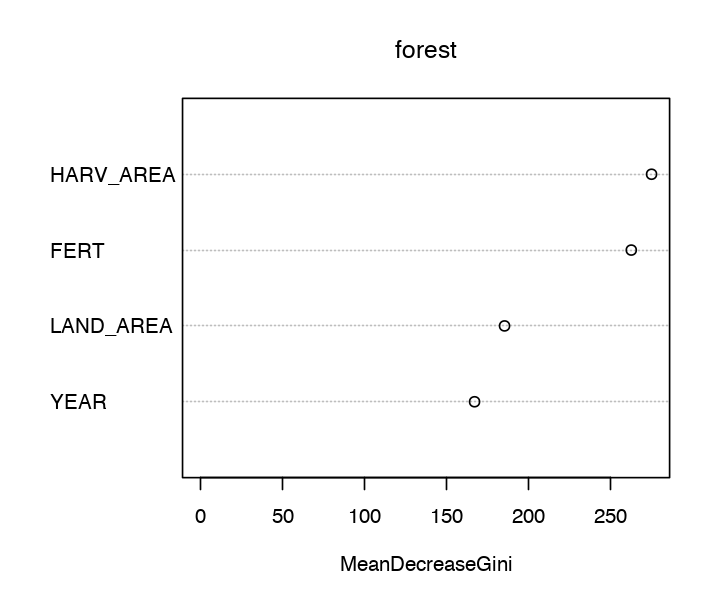

In [266]:
forest <- randomForest(target ~ . , data=Train, ntree=200, mtry=1)

varImpPlot(forest)

In [1000]:
#rf <- predict(forest, type = "class")
#confusionMatrix(rf, Train$target, positive = "Above")

rf <- predict(forest, newdata=Test, type = "class")
confusionMatrix(rf, Test$target, positive = "Above")

Confusion Matrix and Statistics

          Reference
Prediction Above Below
     Above   179   180
     Below   127   107
                                          
               Accuracy : 0.4823          
                 95% CI : (0.4414, 0.5234)
    No Information Rate : 0.516           
    P-Value [Acc > NIR] : 0.953925        
                                          
                  Kappa : -0.0425         
 Mcnemar's Test P-Value : 0.002999        
                                          
            Sensitivity : 0.5850          
            Specificity : 0.3728          
         Pos Pred Value : 0.4986          
         Neg Pred Value : 0.4573          
             Prevalence : 0.5160          
         Detection Rate : 0.3019          
   Detection Prevalence : 0.6054          
      Balanced Accuracy : 0.4789          
                                          
       'Positive' Class : Above           
                                          

In [884]:
table(Test$target)


Above Below 
  306   287 

In [885]:
306/(306+287)

[1] 0.5160202

# Cluster Analysis

In [225]:
# Create data set for each cluster
df_cluster1 = subset(df_detrended,cluster_id==1)
df_cluster2 = subset(df_detrended,cluster_id==2)
df_cluster3 = subset(df_detrended,cluster_id==3)


# Random Forest Model on Clusters

In [239]:
cluster_centres

,AVG_TEMP_JAN,AVG_TEMP_FEB,AVG_TEMP_MAR,AVG_TEMP_APR,AVG_TEMP_MAY,AVG_TEMP_JUN,AVG_TEMP_JUL,AVG_TEMP_AUG,AVG_TEMP_SEP,AVG_TEMP_OCT,⋯,AVG_RF_MAR,AVG_RF_APR,AVG_RF_MAY,AVG_RF_JUN,AVG_RF_JUL,AVG_RF_AUG,AVG_RF_SEP,AVG_RF_OCT,AVG_RF_NOV,AVG_RF_DEC
1,-0.9139926,0.5358739,5.024352,10.34044,15.06090,19.14154,21.35687,20.93695,16.77355,11.37797,⋯,46.37633,54.53914,64.55288,73.13713,81.12206,71.22311,61.48687,51.97886,46.65562,45.42754
2,24.0359879,25.1488650,26.427381,27.23361,27.16674,26.63539,26.08088,25.93994,26.02402,25.98844,⋯,79.80640,114.83842,192.15828,217.47123,237.41794,256.44858,233.07965,202.88168,132.21445,97.43469
3,21.9672502,22.6808928,23.473940,23.82931,23.68084,23.09932,22.66812,23.19086,23.86149,23.93736,⋯,110.86165,89.66226,65.13080,43.18670,45.18882,47.97957,51.79083,69.76430,85.06078,100.09433


In [236]:
# Model features
target_variable = 'target'
attribute_variables = c('COUNTRY','YEAR')
weather_features = c('AVG_TEMP_JAN_Z','AVG_TEMP_FEB_Z','AVG_TEMP_MAR_Z','AVG_TEMP_APR_Z','AVG_TEMP_MAY_Z','AVG_TEMP_JUN_Z',
                     'AVG_TEMP_JUL_Z','AVG_TEMP_AUG_Z','AVG_TEMP_SEP_Z','AVG_TEMP_OCT_Z','AVG_TEMP_NOV_Z','AVG_TEMP_DEC_Z',
                     'AVG_RF_JAN_Z','AVG_RF_FEB_Z','AVG_RF_MAR_Z','AVG_RF_APR_Z','AVG_RF_MAY_Z','AVG_RF_JUN_Z',
                     'AVG_RF_JUL_Z','AVG_RF_AUG_Z','AVG_RF_SEP_Z','AVG_RF_OCT_Z','AVG_RF_NOV_Z','AVG_RF_DEC_Z')

#weather_features = c('AVG_TEMP_JAN','AVG_TEMP_FEB','AVG_TEMP_MAR','AVG_TEMP_APR','AVG_TEMP_MAY','AVG_TEMP_JUN',
#                     'AVG_TEMP_JUL','AVG_TEMP_AUG','AVG_TEMP_SEP','AVG_TEMP_OCT','AVG_TEMP_NOV','AVG_TEMP_DEC',
#                     'AVG_RF_JAN','AVG_RF_FEB','AVG_RF_MAR','AVG_RF_APR','AVG_RF_MAY','AVG_RF_JUN',
#                     'AVG_RF_JUL','AVG_RF_AUG','AVG_RF_SEP','AVG_RF_OCT','AVG_RF_NOV','AVG_RF_DEC')


#
# Create dataframe with variables required for model
#
df_model_data = df_cluster3[,c(target_variable, attribute_variables, weather_features)]




In [237]:
#split = sample.split(df_model_data$target,SplitRatio=0.7)
#Train = subset(df_model_data,split==T)
#Test = subset(df_model_data,split==F)

Train = df_model_data

In [212]:
# Random Search
#control <- trainControl(method="repeatedcv", number=10, repeats=3, search="random")
#control <- trainControl(method="cv", number=10, search="random")
#seed=23
#set.seed(seed)
#metric <- "Accuracy"
#mtry <- sqrt(ncol(Train)-3)
#rf_random <- train(target~. - YEAR - COUNTRY, data=Train, method="rf", ntree=10, metric=metric, tuneLength=15, trControl=control)
#print(rf_random)


In [211]:
#Create control function for training with 10 folds 
#control <- trainControl(method='cv',number=10,search='grid')
control <- trainControl(method="repeatedcv", number=10, repeats=3, search="grid")

#create tunegrid. Our train function will change number of entry variable at each split according to tunegrid. 
tunegrid <- expand.grid(.mtry = (1:24)) 

rf_gridsearch <- train(target~. - YEAR - COUNTRY, data=Train, method="rf", ntree=10, metric = 'Accuracy',tuneGrid = tunegrid, trControl=control)

print(rf_gridsearch)


Random Forest 

2184 samples
  26 predictor
   2 classes: 'Above', 'Below' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1966, 1966, 1965, 1965, 1966, 1966, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa        
   1    0.5016771  -0.0064276068
   2    0.5038310  -0.0032076087
   3    0.4905394  -0.0298044579
   4    0.5114386   0.0124041298
   5    0.5018300  -0.0064409512
   6    0.5120642   0.0142618619
   7    0.5003302  -0.0080801286
   8    0.5064185   0.0027551196
   9    0.5024660  -0.0043465293
  10    0.5103920   0.0123869228
  11    0.5048783   0.0004041903
  12    0.4992501  -0.0111214983
  13    0.4847528  -0.0401217798
  14    0.5015353  -0.0070050288
  15    0.5016827  -0.0059191777
  16    0.5053272   0.0015308259
  17    0.5021602  -0.0063431058
  18    0.4985003  -0.0121370027
  19    0.5058090   0.0024880550
  20    0.4970976  -0.0146432971
  21    0.5122087   0.0141145656
  22    0.

In [213]:
table(Train$target)


Above Below 
 1152  1032 

In [214]:
1152/(1152+1032)

[1] 0.5274725

In [1115]:
forest <- randomForest(target ~ . - YEAR - COUNTRY, data=Train, ntree=500,mtry=24)

rf <- predict(forest, newdata=Test, type = "class")
confusionMatrix(rf, Test$target, positive = "Above")

Confusion Matrix and Statistics

          Reference
Prediction Above Below
     Above    51    45
     Below    38    36
                                          
               Accuracy : 0.5118          
                 95% CI : (0.4341, 0.5891)
    No Information Rate : 0.5235          
    P-Value [Acc > NIR] : 0.6498          
                                          
                  Kappa : 0.0175          
 Mcnemar's Test P-Value : 0.5102          
                                          
            Sensitivity : 0.5730          
            Specificity : 0.4444          
         Pos Pred Value : 0.5312          
         Neg Pred Value : 0.4865          
             Prevalence : 0.5235          
         Detection Rate : 0.3000          
   Detection Prevalence : 0.5647          
      Balanced Accuracy : 0.5087          
                                          
       'Positive' Class : Above           
                                          

In [1122]:
table(Test$target)


Above Below 
  118   115 

In [1123]:
118/(118+115)

[1] 0.5064378

In [1125]:
table(Train$target)
275/(275+269)


Above Below 
  275   269 

[1] 0.5055147

# Annual Total Paddy Rice Production File

Here I detail how I created the file wrs_annual_rice_production.csv. 

On the World Rice Statistics online query engine

http://ricestat.irri.org:8080/wrsv3/entrypoint.htm

I generated a csv file (WRS_paddy_production.csv) for the variable "PRODUCTION - PADDY" for all countries from 1991-2016.

I then read in this file and generated the csv file wrs_annual_rice_production.csv as follows:


In [141]:
# Set the working directory
setwd("/Users/billyhanan/Documents/NCI  Diploma in Data Analytics/Advanced Data Mining/Project")

# Read in WRS file holding annual rice production values
df_rice_production = read.csv("./Data/WRS Data/WRS_paddy_production.csv",header=T)

# Keep FAO source values only
df_rice_production = subset(df_rice_production,Source=="FAO")

# Keep only columns needed
df_rice_production = df_rice_production[,c('Country','Year','Value')]

# Rename the Value column to PRODUCTION
names(df_rice_production)[3] <- "PRODUCTION"

# Remove 2016 data
df_rice_production = df_rice_production[df_rice_production$Year!=2016,]

# Rename some country names that are mis-matched with those in master data frame
levels(df_rice_production$Country)[levels(df_rice_production$Country)=="UNITED STATES OF AMERICA"] = "UNITED STATES"
levels(df_rice_production$Country)[levels(df_rice_production$Country)=="CONGO DR"] = "CONGO"

# Avoid values being converted to scientic notation when writing them out to a file
options(scipen = 999)

# Write data to csv file
write.csv(df_rice_production, file = "./Data/wrs_annual_rice_production.csv",row.names=FALSE,quote=F)